# Understanding the in-situ Solar Wind Properties with Machine Learning and Artificial Intelligence


Project Abstract: 
With the rapid increase of the in-situ measurements of the solar wind plasma, traditional data analysis methods are no longer sufficient for Heliophysics scientists to fully comprehend the scientific insights embedded within the data. Applications of Machine learning (ML) and Artificial Intelligence (AI) techniques on the solar data in order to perform feature selection, dimension reduction and clustering is the major goal of this proposal.

Project Outcome:
1). The importance ranking of the solar wind input data.
2). Visualization of the solar wind data in 2D, after the dimension reduction.
3). Labels of the clustering.
4). Prediction of the monthly sunspot number and the indexes of the HCS


# Descriptive analytics

In [1]:
import pandas as pd
import re
import numpy as np
# from pydantic_settings import BaseSettings #not sure if it's needed
# from ydata_profiling import ProfileReport
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#pip install ydata-profiling
#pip install pydantic-settings 


In [2]:
#Read CSVs

#Just HCS
hcs_df = pd.read_csv('../data/HCS Cleaned.csv')
hcs_df['actual_date'] = pd.to_datetime(hcs_df['actual_date'])  

#HCS + Sunspots
hcs_sun = pd.read_csv("../data/HCS + Sunspots.csv")
hcs_sun['date'] = pd.to_datetime(hcs_sun['date']) 

#HCS + Sinsports + ACE
hcs_sun_ace= pd.read_csv("../data/HCS + Sunspots + ACE.csv")
hcs_sun_ace['date'] = pd.to_datetime(hcs_sun_ace['date']) 

### Creating visualization to see the relationship between the indeces and the sunspots numbers

In [3]:
#Better scale to compare to sunspots
hcs_sun['SD_70*10'] = hcs_sun['SD_70']*10

#Creating a date colum  for the x axis
hcs_sun['date'] = pd.to_datetime(hcs_sun['year'].astype(str) + '-' + hcs_sun['month'].astype(str) + '-01')

hcs_sun

,year,month,SD_70,SL_70,SL_70_log10,fyear_CS,monthly_sunspots,std,observations,date,smoothed_sunspots,SD_70*10
0,1976,6,4.432569,26.940952,1.430413,1976.456,17.9,2.9,30,1976-06-01,21.808333,44.32569
1,1976,7,4.316492,20.119915,1.303626,1976.540,2.9,1.2,31,1976-07-01,23.400000,43.16492
2,1976,8,5.729208,22.427944,1.350681,1976.624,24.1,3.3,31,1976-08-01,22.991667,57.29208
3,1976,9,4.522666,24.674475,1.392248,1976.708,20.0,3.0,30,1976-09-01,22.420833,45.22666
4,1976,10,4.935369,30.268057,1.480985,1976.791,29.7,3.7,31,1976-10-01,24.175000,49.35369
...,...,...,...,...,...,...,...,...,...,...,...,...
473,2015,11,16.819719,841.242554,2.924921,2015.874,62.2,5.2,622,2015-11-01,NaN,168.19719
474,2015,12,18.058346,3870.971680,3.587820,2015.958,58.0,5.4,704,2015-12-01,NaN,180.58346
475,2016,1,17.479214,1126.743408,3.051825,2016.042,57.0,4.7,634,2016-01-01,NaN,174.79214
476,2016,2,16.834934,454.107941,2.657159,2016.124,56.4,5.1,662,2016-02-01,NaN,168.34934


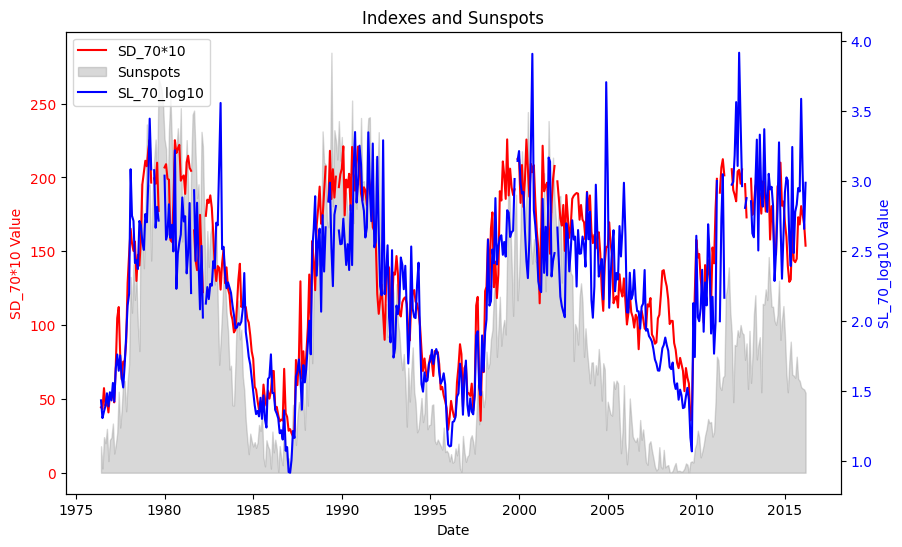

In [4]:
# Creating the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting SD_70*10 on the primary y-axis
ax1.plot(hcs_sun['date'], hcs_sun['SD_70*10'], label='SD_70*10', color='red')

# Setting the label for the primary y-axis
ax1.set_ylabel('SD_70*10 Value', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Creating the secondary y-axis
ax2 = ax1.twinx()  

# Plotting SL_70_log10 on the secondary y-axis
ax2.plot(hcs_sun['date'], hcs_sun['SL_70_log10'], label='SL_70_log10', color='blue')

# Setting the label for the secondary y-axis
ax2.set_ylabel('SL_70_log10 Value', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Plotting the area plot for monthly_sunspots on the primary y-axis for simplicity
ax1.fill_between(hcs_sun['date'], hcs_sun['monthly_sunspots'], color='gray', alpha=0.3, label='Sunspots')

# Customization
ax1.set_xlabel('Date')
ax1.set_title('Indexes and Sunspots')

# Handling legends. Since we have plots on two different axes, handle them separately
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

### Baseline using Moving Average

In [5]:
#Window
N = 4

#Creating Moving Average Columns
hcs_sun_ace['moving_average_SD_70'] = hcs_sun_ace['SD_70'].rolling(window=N).mean()
hcs_sun_ace['moving_average_SL_70_log10'] = hcs_sun_ace['SL_70_log10'].rolling(window=N).mean()

In [6]:
hcs_sun_ace.head()

,year,month,SD_70,SL_70,SL_70_log10,fyear_CS,monthly_sunspots,std,observations,date,smoothed_sunspots,SD_70*10,proton_density,proton_temp,He4toprotons,proton_speed,PC1,PC2,moving_average_SD_70,moving_average_SL_70_log10
0,1998,2,12.301438,82.789337,1.917974,1998.123,50.2,4.6,559,1998-02-01,61.745833,123.014380,10.668186,55818.621443,0.022320,377.004722,-1.249865,-0.740865,NaN,NaN
1,1998,3,12.602894,159.079344,2.008504,1998.204,82.0,5.9,571,1998-03-01,65.370833,126.028935,9.296941,71053.688126,0.030932,402.813548,-0.854332,-0.273900,NaN,NaN
2,1998,4,15.813673,380.628082,2.580501,1998.288,70.6,7.2,537,1998-04-01,69.179167,158.136730,8.991568,71262.155483,0.037028,379.456547,-1.017707,-0.005488,NaN,NaN
3,1998,5,12.578657,128.306992,2.108250,1998.371,74.0,4.8,620,1998-05-01,72.120833,125.786570,6.943908,100056.671947,0.031098,452.484785,-0.047913,-0.120904,13.324165,2.153807
4,1998,6,16.536440,138.153671,2.140362,1998.455,90.5,6.0,521,1998-06-01,77.295833,165.364400,8.368127,69987.706731,0.024842,414.453910,-0.684110,-0.465511,14.382916,2.209404


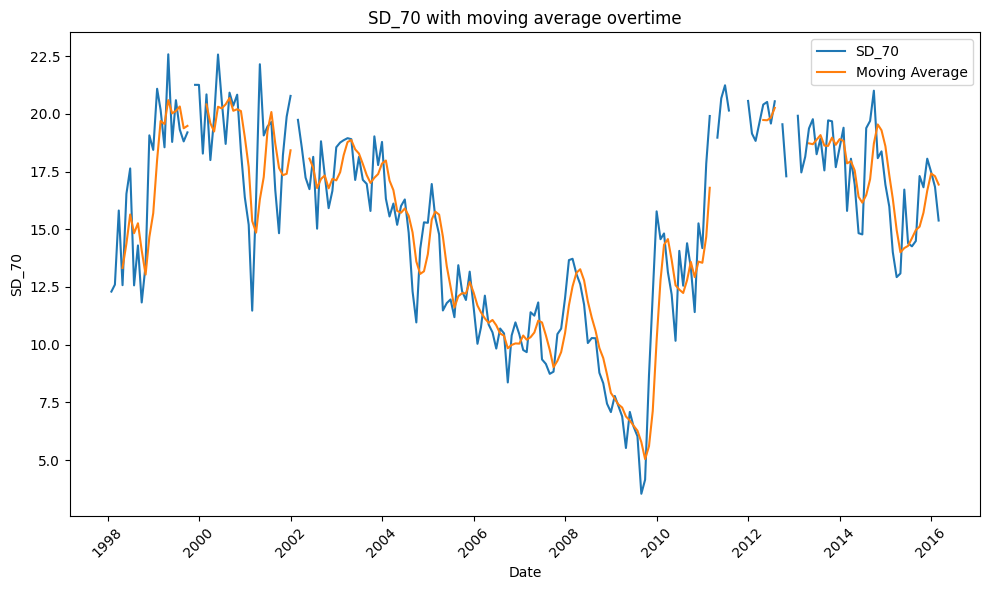

In [7]:
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['SD_70'], label='SD_70')  # Plot series 1
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['moving_average_SD_70'], label='Moving Average')  # Plot series 2

# Formatting the plot
plt.title('SD_70 with moving average overtime')
plt.xlabel('Date')
plt.ylabel('SD_70')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Display the plot
plt.show()

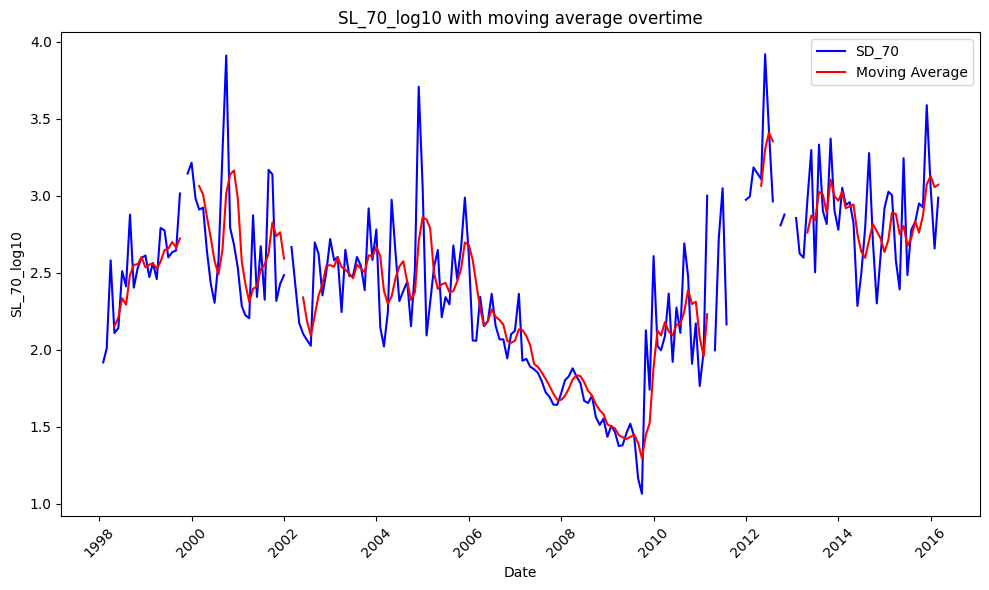

In [8]:
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['SL_70_log10'], label='SD_70', color='blue')  # Plot series 1
plt.plot(hcs_sun_ace['date'], hcs_sun_ace['moving_average_SL_70_log10'], label='Moving Average', color='red')  # Plot series 2

# Formatting the plot
plt.title('SL_70_log10 with moving average overtime')
plt.xlabel('Date')
plt.ylabel('SL_70_log10')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Display the plot
plt.show()

# Seasonal Decomposition

In [9]:
#Creating function to get seasonal decomposition, which we learned on Data Mining II

def sea_decomp(ser, model="additive"):
    """
    Takes in a series and a "model" parameter indicating which seasonal decomp to perform
    """
    result = seasonal_decompose(ser, model=model)
    
    return result


In [10]:
#Creating df to not mess up the original one
hcs_sun_ace_decomp = hcs_df.copy()

# Convert 'date' to datetime and set as index
hcs_sun_ace_decomp['date'] = pd.to_datetime(hcs_sun_ace_decomp['actual_date'])
hcs_sun_ace_decomp.set_index('date', inplace=True)

# Set the frequency of the index to monthly
hcs_sun_ace_decomp = hcs_sun_ace_decomp.asfreq('ME')

#Filling missing values because the function can't handle them
hcs_sun_ace_decomp['SD_70'].fillna(1, inplace=True)



/var/folders/sm/z_t_tmn967ng03q4_p3txtch0000gn/T/ipykernel_2508/3491868127.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hcs_sun_ace_decomp['SD_70'].fillna(1, inplace=True)


Text(0.513, 0.95, 'HCS')

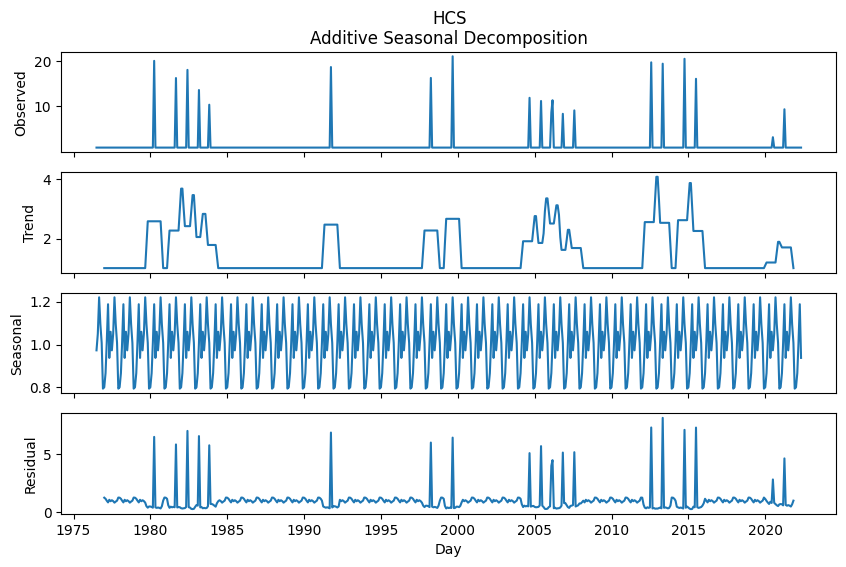

In [11]:
#Plotting seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
res = sea_decomp(hcs_sun_ace_decomp['SD_70'], model="multiplicative")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Day")
fig.suptitle("HCS", x=0.513, y=0.95)